In [100]:
# Imports
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from transformers import CLIPTextModel, CLIPTokenizer, CLIPTextModelWithProjection
from diffusers import AutoencoderKL, UNet2DConditionModel, AutoPipelineForText2Image
from diffusers import LMSDiscreteScheduler
from deep_translator import GoogleTranslator
import re
import cv2
import numpy as np
import ezdxf

# device to be used
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

Using device cpu


In [85]:
def hebrew_translator(user_prompt):
    """
    function for testing whether user's input is in Hebrew or in English - if it's
    in Hebrew then it will translate it to English
    :param user_prompt:
    :return:
    """
    contains_hebrew = re.search(r"[\u0590-\u05FF]", user_prompt) is not None
    if contains_hebrew:
        return GoogleTranslator(source='auto', target='en').translate(user_prompt)
    else:
        prompt_en = user_prompt

    return prompt_en

In [86]:
def add_nikud(text):
    """
    שואלת את המשתמש לגבי אותיות בעייתיות (ב, כ, פ),
    ומחזירה גרסה "מנוקדת" שבה דגש מסומן באות + U+05BC.
    """

    DAGESH = '\u05BC'
    ambiguous = ['ב', 'כ', 'פ']

    result = ""

    for ch in text:
        if ch in ambiguous:
            # שואלים את המשתמש
            ans = input(f"האם האות '{ch}' במילה '{text}' היא עם דגש? (כן/לא) ").strip().lower()

            if ans == 'כן':
                result += ch + DAGESH   # הוספת דגש
            else:
                result += ch
        else:
            result += ch

    return result

In [1]:
# Braille
# ==========================================================
# זיהוי ניקוד — כולל דגש
# ==========================================================
DAGESH = '\u05BC'  # נקודה במרכז האות

def has_dagesh(char):
    # מחזיר True אם יש דגש על האות
    return DAGESH in char


# ==========================================================
# טבלת ברייל עברית — בסיסית
# ==========================================================

# אותיות ללא דגש
HEBREW_MAP = {
    'א': '⠁',
    'ב': '⠧',  # ללא דגש → v
    'ג': '⠛',
    'ד': '⠙',
    'ה': '⠓',
    'ו': '⠺',
    'ז': '⠵',
    'ח': '⠭',
    'ט': '⠞',
    'י': '⠚',
    'כ': '⠡',  # כ רפויה
    'ל': '⠇',
    'מ': '⠍',
    'נ': '⠝',
    'ס': '⠎',
    'ע': '⠫',
    'פ': '⠋',  # פ רפויה (f)
    'צ': '⠮',
    'ק': '⠟',
    'ר': '⠗',
    'ש': '⠩',  # SH
    'ת': '⠹'
}

# אותיות עם דגש (כמו בּ, כּ, פּ)
HEBREW_DAGESH_MAP = {
    'ב': '⠃',  # B
    'כ': '⠅',  # K
    'פ': '⠏',  # P
}

FINAL_FORMS = {
    'ך': 'כ',
    'ם': 'מ',
    'ן': 'נ',
    'ף': 'פ',
    'ץ': 'צ',
}

FINAL_MARK = '⠘'

# ==========================================================
# תרגום לברייל → לפי ניקוד
# ==========================================================

def letter_to_braille(char):
    base = char[0]
    is_final = False

    if base in FINAL_FORMS:
        base = FINAL_FORMS[base]
        is_final = True

    if has_dagesh(char) and base in HEBREW_DAGESH_MAP:
        braille = HEBREW_DAGESH_MAP[base]
    else:
        braille = HEBREW_MAP.get(base, base)

    if is_final:
        return FINAL_MARK + braille

    return braille

# ==========================================================
# תרגום משפט שלם לברייל
# ==========================================================

def convert_to_braille(text):
    result = []
    i = 0
    DAGESH = '\u05BC'

    while i < len(text):
        ch = text[i]

        # אם זה אות עברית
        if 'א' <= ch <= 'ת':
            # בדיקה האם יש דגש אחרי האות
            if i + 1 < len(text) and text[i + 1] == DAGESH:
                combined = ch + DAGESH   # אות עם דגש
                result.append(letter_to_braille(combined))
                i += 2
                continue
            else:
                # אות רגילה ללא דגש
                result.append(letter_to_braille(ch))
                i += 1
                continue

        # אם זה סימן ניקוד אחר — מדלגים
        if '\u0591' <= ch <= '\u05C7':
            i += 1
            continue

        # כל דבר אחר
        result.append(ch)
        i += 1

    result = result[::-1]

    return "".join(result)

In [88]:
def convert_tensor_to_pil_img(tensor):
    """
    function converts a tensor of size CxHxW in [-1,1] to a PIL image in [0,255]
    :param x (torch.Tensor): input tensor.
    :return image (PIL.Image): output image.
    """
    image = (tensor / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)
    return image

In [89]:
def img_to_dxf(img_location, dxf_location="output.dxf"):
    # Load image
    img = cv2.imread(img_location, cv2.IMREAD_GRAYSCALE)

    # Threshold to black/white
    _, th = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create DXF
    doc = ezdxf.new()
    msp = doc.modelspace()

    for cnt in contours:
        # Convert contour to (x, y) points
        points = [(float(p[0][0]), float(p[0][1])) for p in cnt]
        # Add polyline to DXF
        msp.add_lwpolyline(points, close=True)

    doc.saveas(dxf_location)

In [101]:
# general settings of Stable Diffusion
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
    # GPU → float16
    pipe = AutoPipelineForText2Image.from_pretrained(
        "segmind/SSD-1B",
        torch_dtype=torch.float16
    ).to(device)

else:
    # CPU → float32
    pipe = AutoPipelineForText2Image.from_pretrained(
        "segmind/SSD-1B",
        torch_dtype=torch.float32
    ).to(device)

model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

C:\Users\Danna\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Danna\.cache\huggingface\hub\models--segmind--SSD-1B. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_m

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder_2/model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.33G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [102]:
## text to image generator from user's input ##

# desired text prompt
hebrew_prompt  = input(" :בבקשה הכנס/י את התמונה שתרצי/שתרצה בספר")
general_prompt = hebrew_translator(hebrew_prompt)
type  = input(" :בבקשה הכנס/י את הקטגוריה של התמונה (פרי, ירק, מספר, אות)")
type = hebrew_translator(type)
user_prompt = (
    f"A single clean line-art illustration of {general_prompt}, "
    f"classified as a {type}. "
    "Minimalistic outline, high contrast white background, no shading, no texture, "
    "sharp edges, centered composition, no extra objects, no text, no noise."
)
user_prompt = [user_prompt]

# Generate the image
image = pipe(user_prompt, num_inference_steps=25, guidance_scale=7.5).images[0]

  0%|          | 0/25 [00:00<?, ?it/s]

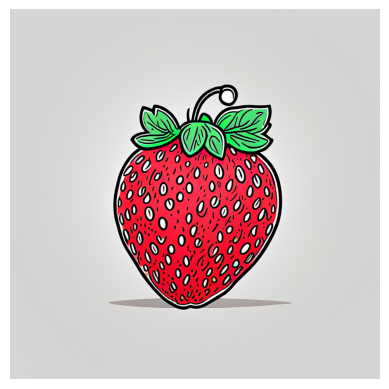

In [119]:
# plot results
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

In [2]:
## Braille converter
hebrew_prompt = add_nikud(hebrew_prompt)
Braille = convert_to_braille(hebrew_prompt)
print(Braille)

NameError: name 'add_nikud' is not defined

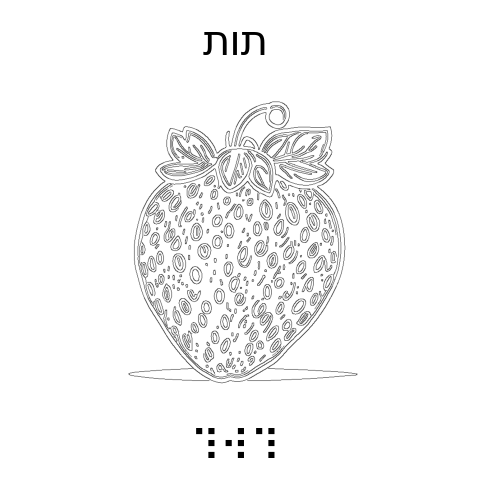

In [118]:
#image processing
image = np.array(image)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray_image, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)
kernel = np.ones((1, 1), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
edges = cv2.bitwise_not(edges)
h, w = edges.shape
edges[h-1:h, w-1:w] = 255


#centering object
h, w = edges.shape
ys, xs = np.where(edges[1:h-1,1:w-1] == 0)
obj_cx = xs.mean()
obj_cy = ys.mean()
img_cx = w / 2
img_cy = h / 2
shift_x = int(img_cx - obj_cx)
shift_y = int(img_cy - obj_cy)
M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
centered = cv2.warpAffine(edges, M, (w, h), borderValue=255)

#plotting final result
plt.figure(figsize=(6,6))
plt.text(500, 100, f'{hebrew_prompt[::-1]}', fontsize=30, color='black', ha='center') #English text
plt.text(500, 1000, f'{Braille}', fontsize=30, color='black', ha='center') #Braille text
plt.imshow(centered, cmap="gray")
plt.axis("off")
plt.show()


In [120]:
# Saving as dxfd
filename = "output.png"
cv2.imwrite(filename, centered)
img_to_dxf(filename)